In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [10]:
benchmark = pd.read_json('benchmark_MCR_results.json')
benchmark.head

FileNotFoundError: File benchmark_MCR_results.json does not exist

In [106]:
# Create the NumPy DataFrame
np_benchmark = benchmark[['grid_size', 'resolution', 'np_runtime']].copy()

# Create the PyTorch DataFrame
torch_benchmark = benchmark[['grid_size', 'resolution', 'torch_runtime']].copy()

np_benchmark = np_benchmark.rename(columns={'np_runtime': 'runtime'})
torch_benchmark = torch_benchmark.rename(columns={'torch_runtime': 'runtime'})

# framework indicator 
np_benchmark['framework'] = 'NumPy'
torch_benchmark['framework'] = 'PyTorch'

print("NumPy Data:")
print(np_benchmark.head())

print("\nPyTorch Data:")
print(torch_benchmark.head())

NumPy Data:
   grid_size  resolution   runtime framework
0         50          50  0.000026     NumPy
1         50         100  0.000024     NumPy
2         50         150  0.000026     NumPy
3         50         200  0.000024     NumPy
4         50         250  0.000023     NumPy

PyTorch Data:
   grid_size  resolution   runtime framework
0         50          50  0.000341   PyTorch
1         50         100  0.000361   PyTorch
2         50         150  0.000396   PyTorch
3         50         200  0.000359   PyTorch
4         50         250  0.000445   PyTorch


In [107]:
combined_df = pd.concat([np_benchmark, torch_benchmark], ignore_index=True)

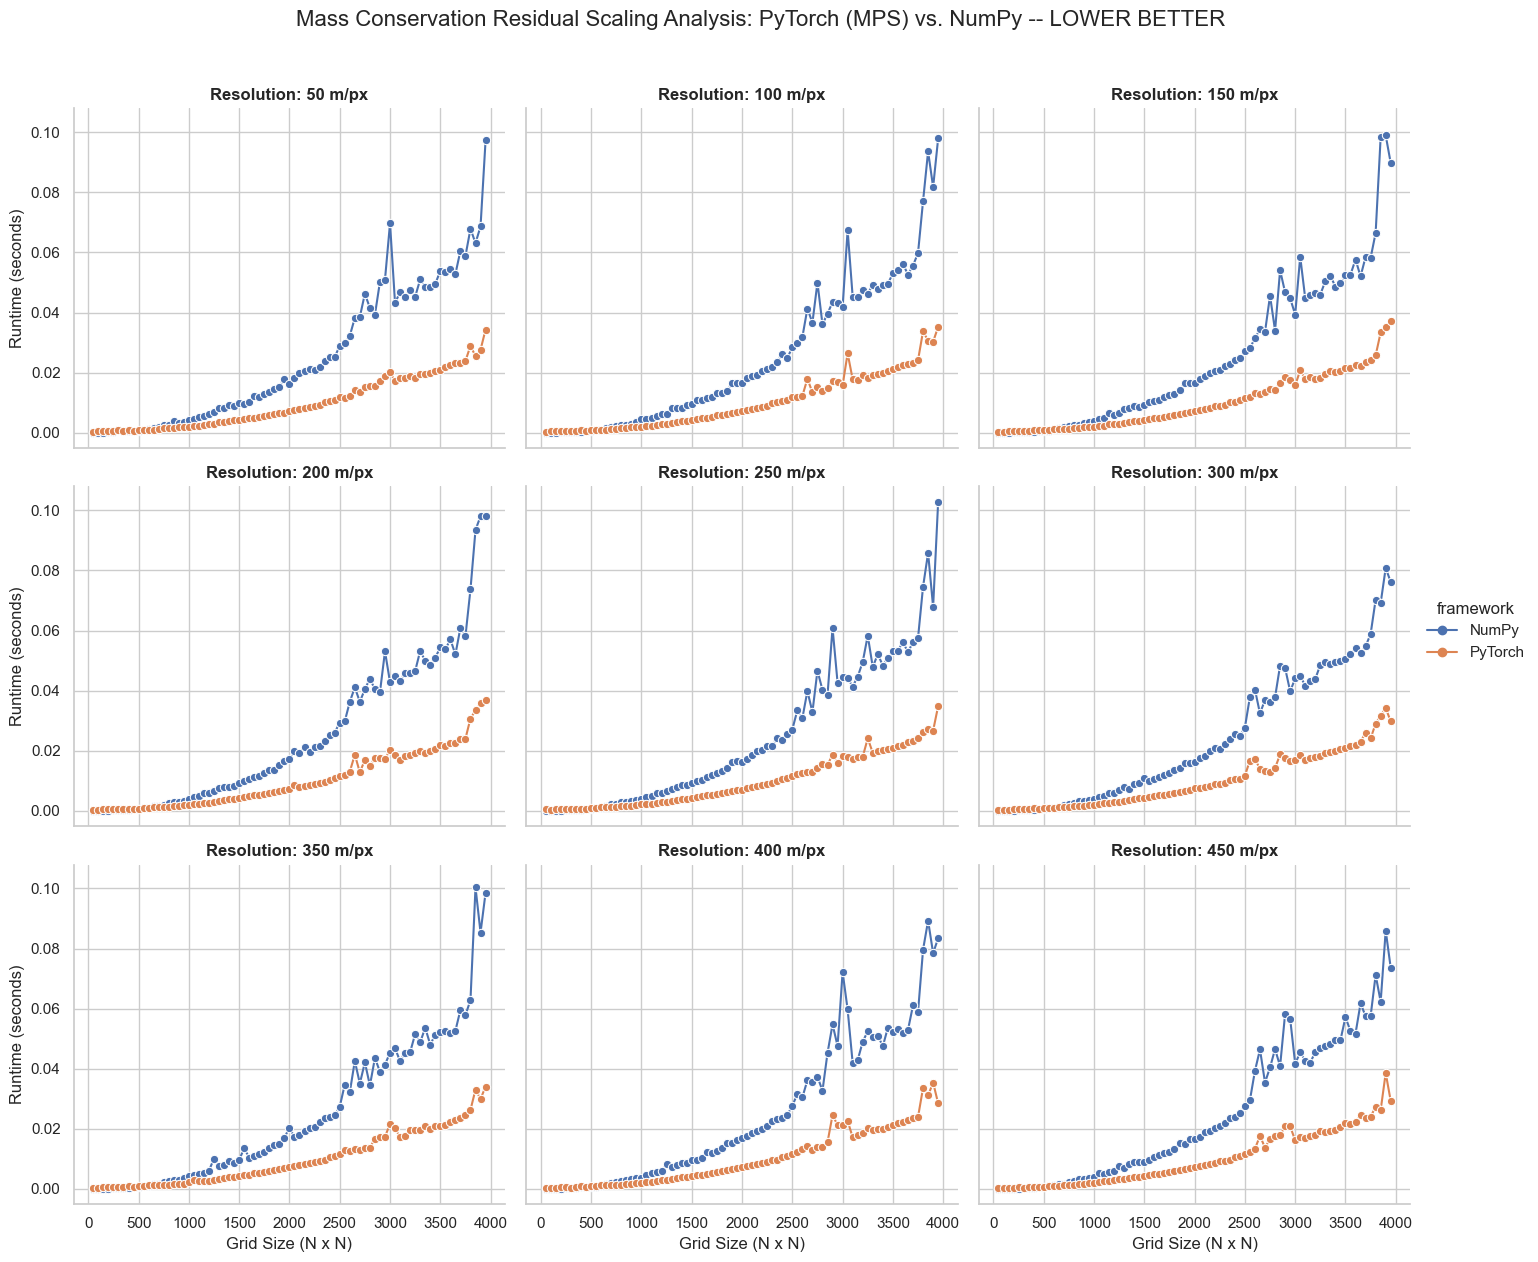

In [118]:
sns.set_theme(style="whitegrid")

# Creating a faceted line plot for better clarity
g = sns.relplot(
    data=combined_df, 
    x='grid_size', 
    y='runtime',
    hue='framework', 
    col='resolution',    # Facet by resolution instead of using size
    col_wrap=3,          # Wrap into 3 columns
    kind='line',         # Line plot is better for scaling trends
    marker='o',
    height=4, 
    aspect=1.2
)

# Apply log scale to see small-grid details
#g.set(yscale="log") 

g.set_axis_labels("Grid Size (N x N)", "Runtime (seconds)")
g.set_titles("Resolution: {col_name} m/px", fontweight='bold')
g.figure.suptitle("Mass Conservation Residual Scaling Analysis: PyTorch (MPS) vs. NumPy -- LOWER BETTER" , y=1.05, fontsize=16)

plt.show()

In [11]:
DF_MCMC = pd.read_json("benchmark_results.json")
#DF_MCMC_GPU = pd.read_json("benchmark_results_gpuOnly.json")

dict_keys(['backend', 'n_iter', 'wall_time_s', 'iter_per_sec', 'acceptance_rate', 'loss_total', 'loss_mc', 'loss_data', 'steps_accepted', 'loss_summary', 'mass_conservation_summary', 'final_mc_residual_in_region'])

In [12]:
np_df_mcmc = DF_MCMC['results']['cpu'] # ["n_iter", "wall_time_s", "iter_per_sec", "acceptance_rate", "loss_total"]
torch_df_mcmc = DF_MCMC['results']['gpu']
np_df_mcmc.keys()

dict_keys(['backend', 'n_iter', 'wall_time_s', 'iter_per_sec', 'acceptance_rate', 'loss_total', 'loss_mc', 'loss_data', 'steps_accepted', 'loss_summary', 'mass_conservation_summary', 'final_mc_residual_in_region'])

In [13]:
np_n_iter       = np_df_mcmc["n_iter"]
np_loss_total   = np.array(np_df_mcmc["loss_total"])
np_steps        = np.array(np_df_mcmc["steps_accepted"])
np_iter_per_sec = np_df_mcmc["iter_per_sec"]
np_wall_time    = np_df_mcmc["wall_time_s"]

torch_n_iter       = torch_df_mcmc["n_iter"]
torch_loss_total   = np.array(torch_df_mcmc["loss_total"])
torch_steps        = np.array(torch_df_mcmc["steps_accepted"])
torch_iter_per_sec = torch_df_mcmc["iter_per_sec"]
torch_wall_time    = torch_df_mcmc["wall_time_s"]


In [14]:
def add_stat_box(ax, lines, color="#1e2536"):
    txt = "\n".join(lines)
    ax.text(0.98, 0.97, txt,
            transform=ax.transAxes,
            ha="right", va="top",
            fontsize=8.5, color="#c9d1e0",
            bbox=dict(boxstyle="round,pad=0.4", facecolor=color,
                      edgecolor="#2a2f3d", alpha=0.85))
    
def get_acf(loss_array, max_lag=500):
    """
    measures the linear relationship (correlation) between a time series and a lagged, or delayed, version of itself across different time intervals
    """
    x = loss_array - np.mean(loss_array)
    var = np.var(loss_array) * len(loss_array)
    
    acf = np.zeros(max_lag + 1)
    acf[0] = 1.0
    for lag in range(1, max_lag + 1):
        # Dot product of overlapping segments
        cov = np.sum(x[:-lag] * x[lag:])
        acf[lag] = cov / var
    return acf

In [15]:
max_lag = 500
lags = np.arange(max_lag + 1)

np_acf = get_acf(np_loss_total, max_lag=max_lag)
torch_acf = get_acf(torch_loss_total, max_lag=max_lag)

# np.argmax returns the first index where the condition is True
np_decorr_lag = np.argmax(np_acf < 0.05) 
torch_decorr_lag = np.argmax(torch_acf < 0.05)

# Fallback in case it never drops below 0.05 within max_lag
np_decorr_lag = np_decorr_lag if np_decorr_lag > 0 else ">500"
torch_decorr_lag = torch_decorr_lag if torch_decorr_lag > 0 else ">500"

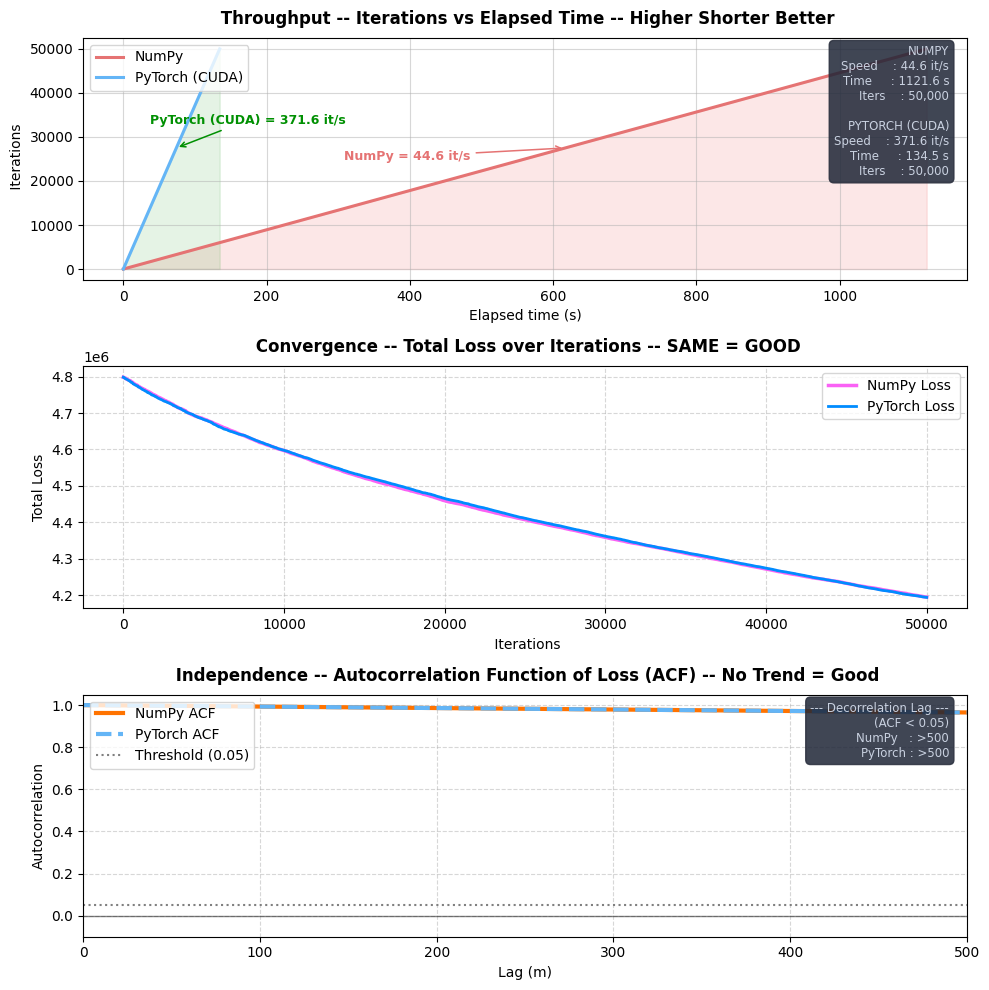

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), facecolor='#ffffff')
# cumulative iterations vs elapsed time

ax1 = axes[0]
elapsed_axis = np.linspace(0, np_wall_time, np_n_iter)   
cum_iters    = np.arange(1, np_n_iter + 1)

# PyTorch Data
torch_elapsed_axis = np.linspace(0, torch_wall_time, torch_n_iter)
torch_cum_iters    = np.arange(1, torch_n_iter + 1)

# plot numpy -- red
ax1.plot(elapsed_axis, cum_iters, color='#e57373', linewidth=2.2, label="NumPy")
ax1.fill_between(elapsed_axis, cum_iters, alpha=0.10, color="#eb1818")

# plot torch -- blue
ax1.plot(torch_elapsed_axis, torch_cum_iters, color='#64b5f6', linewidth=2.2, label="PyTorch (CUDA)")
ax1.fill_between(torch_elapsed_axis, torch_cum_iters, alpha=0.10, color="#009002")

# labels
ax1.set_title(" Throughput -- Iterations vs Elapsed Time -- Higher Shorter Better", fontweight="bold", pad=10)
ax1.set_xlabel("Elapsed time (s)")
ax1.set_ylabel(" Iterations")
ax1.grid(True, axis="both", alpha=0.5)
ax1.legend(loc="upper left")

# Annotation of slope
mid_t = np_wall_time * 0.55
mid_i = mid_t * np_iter_per_sec
ax1.annotate(
    f"NumPy = {np_iter_per_sec:.1f} it/s",
    xy=(mid_t, mid_i),
    xytext=(mid_t * 0.5, mid_i * 0.9), # to avoid overlap
    color="#e57373", fontsize=9, fontweight="bold",
    arrowprops=dict(arrowstyle="->", color="#e57373", lw=1.1),
)

# PyTorch Annotation
torch_mid_t = torch_wall_time * 0.55
torch_mid_i = torch_mid_t * torch_iter_per_sec
ax1.annotate(
    f"PyTorch (CUDA) = {torch_iter_per_sec:.1f} it/s",
    xy=(torch_mid_t, torch_mid_i),
    xytext=(torch_mid_t * 0.5, torch_mid_i * 1.2), # lower to avoid overlap
    color="#009002", fontsize=9, fontweight="bold",
    arrowprops=dict(arrowstyle="->", color="#009002", lw=1.1),
)

# Stat box
add_stat_box(ax1, [
    "NUMPY",
    f"Speed    : {np_iter_per_sec:.1f} it/s",
    f"Time     : {np_wall_time:.1f} s",
    f"Iters    : {np_n_iter:,}",
    "\nPYTORCH (CUDA)",
    f"Speed    : {torch_iter_per_sec:.1f} it/s",
    f"Time     : {torch_wall_time:.1f} s",
    f"Iters    : {torch_n_iter:,}"
])

# LOSS TRACE

ax2 = axes[1]
ax2.plot(cum_iters, np_loss_total, color="#fa61f5", linewidth=2.5, alpha=1.0, 
         label="NumPy Loss")

ax2.plot(torch_cum_iters, torch_loss_total, color="#008cff", linewidth=2.0, alpha=1.0, 
         label="PyTorch Loss")

ax2.set_title(" Convergence -- Total Loss over Iterations -- SAME = GOOD", fontweight="bold", pad=10)
ax2.set_xlabel(" Iterations")
ax2.set_ylabel("Total Loss")

# Log scale
#ax2.set_yscale('log') 

ax2.grid(True, axis="both", alpha=0.5, linestyle='--')
ax2.legend(loc="upper right")


# Autocorreleation Function
ax3 = axes[2]

# Plot NumPy ACF
ax3.plot(lags, np_acf, color="#ff7300", linewidth=3, label="NumPy ACF")

# Plot PyTorch ACF
ax3.plot(lags, torch_acf, color='#64b5f6', linewidth=3, linestyle='--', label="PyTorch ACF")

ax3.set_title(" Independence -- Autocorrelation Function of Loss (ACF) -- No Trend = Good", fontweight="bold", pad=10)
ax3.set_xlabel("Lag (m)")
ax3.set_ylabel("Autocorrelation")
ax3.set_xlim(0, max_lag)
ax3.set_ylim(-0.1, 1.05)

# Add reference lines for 0 and the 0.05 threshold
ax3.axhline(0, color='black', linewidth=1, alpha=0.5)
ax3.axhline(0.05, color='gray', linestyle=':', linewidth=1.5, label="Threshold (0.05)")

ax3.grid(True, axis="both", alpha=0.5, linestyle='--')
ax3.legend(loc="upper left")

add_stat_box(ax3, [
    "--- Decorrelation Lag ---",
    "(ACF < 0.05)",
    f"NumPy   : {np_decorr_lag}",
    f"PyTorch : {torch_decorr_lag}"
])

plt.tight_layout()